In [1]:
from google_play_scraper import Sort, reviews
import pandas as pd
from pathlib import Path
import time
import random

APP_ID = "com.openai.chatgpt"
DATA_FILE = Path("play_reviews_ingested.csv")

def load_existing_ids_and_token():
    """
    支持断点续跑：
    - 已存在 CSV：读取 review_id 去重
    - continuation_token：存到单独文件里（可选）
    """
    existing_ids = set()
    if DATA_FILE.exists():
        df = pd.read_csv(DATA_FILE)
        if "review_id" in df.columns:
            existing_ids = set(df["review_id"].astype(str))
    token_file = DATA_FILE.with_suffix(".token")
    token = None
    if token_file.exists():
        token = token_file.read_text().strip() or None
    return existing_ids, token

def save_token(token):
    token_file = DATA_FILE.with_suffix(".token")
    token_file.write_text("" if token is None else str(token))

def append_rows_to_csv(rows):
    if not rows:
        return
    df_new = pd.DataFrame(rows)

    # 统一列名（google_play_scraper 返回字段可能随版本略有差异）
    # 常见：reviewId/userName/content/score/at/replyContent/repliedAt/thumbsUpCount/appVersion
    rename_map = {
        "reviewId": "review_id",
        "userName": "user_name",
        "content": "content",
        "score": "score",
        "at": "at",
        "replyContent": "reply_content",
        "repliedAt": "replied_at",
        "thumbsUpCount": "thumbs_up_count",
        "appVersion": "app_version",
    }
    df_new = df_new.rename(columns=rename_map)

    # 确保关键列存在
    if "review_id" not in df_new.columns and "reviewId" in df_new.columns:
        df_new["review_id"] = df_new["reviewId"].astype(str)
    if "review_id" in df_new.columns:
        df_new["review_id"] = df_new["review_id"].astype(str)

    # 追加写入（有文件就不写 header）
    write_header = not DATA_FILE.exists()
    df_new.to_csv(DATA_FILE, mode="a", header=write_header, index=False)

def fetch_reviews(target_new=10000, per_call=200, max_total_calls=2000):
    """
    target_new：本次想新增多少条（不含历史已有）
    per_call：每次 API 拉多少条（google_play_scraper 的 count）
    """
    existing_ids, continuation_token = load_existing_ids_and_token()
    new_rows_buffer = []
    new_count = 0

    start_time = time.time()
    calls = 0
    seen_existing_streak = 0

    print(f"[START] existing reviews: {len(existing_ids):,}")
    print(f"[START] target new reviews: {target_new:,}")

    while new_count < target_new and calls < max_total_calls:
        calls += 1
        t0 = time.time()

        try:
            result, continuation_token = reviews(
                APP_ID,
                lang="en",
                country="us",
                sort=Sort.NEWEST,
                count=per_call,
                continuation_token=continuation_token,
            )
        except Exception as e:
            # 简单重试/退避
            wait_s = 2 + random.random() * 2
            print(f"[WARN] call #{calls} failed: {e} | retry after {wait_s:.1f}s")
            time.sleep(wait_s)
            continue

        fetched = len(result)
        added_this_call = 0

        for r in result:
            rid = str(r.get("reviewId") or r.get("review_id") or "")
            if not rid:
                continue
            if rid in existing_ids:
                continue
            existing_ids.add(rid)
            new_rows_buffer.append(r)
            new_count += 1
            added_this_call += 1

            # 分批落盘，防止内存变大 & 意外中断丢数据
            if len(new_rows_buffer) >= 500:
                append_rows_to_csv(new_rows_buffer)
                new_rows_buffer.clear()
                save_token(continuation_token)

            if new_count >= target_new:
                break

        # 如果这次全是旧的，累积 streak，避免死循环
        if added_this_call == 0:
            seen_existing_streak += 1
        else:
            seen_existing_streak = 0

        dt = time.time() - t0
        elapsed = time.time() - start_time
        rate = new_count / elapsed if elapsed > 0 else 0

        print(
            f"[{calls:04d}] fetched={fetched:3d} added={added_this_call:3d} "
            f"total_new={new_count:,} token={'Y' if continuation_token else 'N'} "
            f"dt={dt:.2f}s rate={rate:.2f}/s"
        )

        # 如果连续很多次都没加到新数据，说明刷到重复区间了
        if seen_existing_streak >= 20:
            print("[STOP] too many consecutive calls with 0 new reviews (likely saturated or paging loop).")
            break

        # 轻微 sleep，避免请求过快
        time.sleep(0.3 + random.random() * 0.3)

        # 若 token 为空，代表到头了
        if not continuation_token:
            print("[STOP] continuation_token is None (no more pages).")
            break

    # 收尾：把 buffer 写进去
    if new_rows_buffer:
        append_rows_to_csv(new_rows_buffer)
        new_rows_buffer.clear()
        save_token(continuation_token)

    total_elapsed = time.time() - start_time
    print(f"[DONE] new added: {new_count:,} | total elapsed: {total_elapsed/60:.1f} min")
    print(f"[DONE] saved to: {DATA_FILE.resolve()}")
    print(f"[DONE] token saved to: {DATA_FILE.with_suffix('.token').resolve()}")

# ✅ 运行：新增抓 10,000 条（你也可以先 2,000 试跑）
fetch_reviews(target_new=10000, per_call=200)


[START] existing reviews: 200
[START] target new reviews: 10,000
[0001] fetched=200 added=200 total_new=200 token=Y dt=0.42s rate=473.87/s
[0002] fetched=200 added=200 total_new=400 token=Y dt=0.45s rate=280.23/s
[0003] fetched=200 added=200 total_new=600 token=Y dt=0.42s rate=268.10/s
[0004] fetched=200 added=200 total_new=800 token=Y dt=0.33s rate=258.06/s
[0005] fetched=200 added=200 total_new=1,000 token=Y dt=0.34s rate=259.33/s
[0006] fetched=200 added=200 total_new=1,200 token=Y dt=0.40s rate=256.03/s
[0007] fetched=200 added=200 total_new=1,400 token=Y dt=0.32s rate=259.60/s
[0008] fetched=200 added=200 total_new=1,600 token=Y dt=0.36s rate=262.85/s
[0009] fetched=200 added=200 total_new=1,800 token=Y dt=0.33s rate=267.27/s
[0010] fetched=200 added=200 total_new=2,000 token=Y dt=0.34s rate=269.69/s
[0011] fetched=200 added=200 total_new=2,200 token=Y dt=0.32s rate=264.33/s
[0012] fetched=200 added=200 total_new=2,400 token=Y dt=0.33s rate=263.78/s
[0013] fetched=200 added=200 to

In [3]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 8.3/8.3 MB 50.1 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 49.4 MB/s  0:00:00
   ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
   ---------------------------------------- 7.2/7.2 MB 57.3 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pi

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("play_reviews_ingested.csv")

# 统一字段（如果 ingestion 已经rename过，这里会直接存在）
# at/replied_at 可能是字符串，转时间
for col in ["at", "replied_at"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# 基础清洗
if "content" in df.columns:
    df["content"] = df["content"].astype(str)
    df["review_len"] = df["content"].str.len()
    df["word_count"] = df["content"].str.split().str.len()

print("Rows:", len(df))
print(df[["score", "review_len", "word_count"]].describe(include="all"))

# 1) Rating distribution
plt.figure()
df["score"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# 2) Rating over time（按周）
if "at" in df.columns:
    df_time = df.dropna(subset=["at"]).copy()
    df_time["week"] = df_time["at"].dt.to_period("W").dt.start_time
    weekly = df_time.groupby("week")["score"].mean()
    plt.figure()
    weekly.plot()
    plt.title("Average rating over time (weekly)")
    plt.xlabel("Week")
    plt.ylabel("Avg score")
    plt.show()

# 3) Relationship between rating and review length
plt.figure()
df.boxplot(column="review_len", by="score")
plt.suptitle("")
plt.title("Review length by rating")
plt.xlabel("Score")
plt.ylabel("Review length (chars)")
plt.show()

# 4) App version effects（版本 vs 平均评分/评论长度）
if "app_version" in df.columns:
    dv = df.dropna(subset=["app_version"]).copy()
    # 只看出现次数多的版本，避免噪声
    top_versions = dv["app_version"].value_counts().head(10).index
    dv = dv[dv["app_version"].isin(top_versions)]

    stats = dv.groupby("app_version").agg(
        n=("score", "size"),
        avg_score=("score", "mean"),
        avg_len=("review_len", "mean")
    ).sort_values("n", ascending=False)

    print("\nTop app versions summary:")
    print(stats)

    plt.figure()
    stats["avg_score"].plot(kind="bar")
    plt.title("Avg score by app version (top 10 by count)")
    plt.xlabel("App version")
    plt.ylabel("Avg score")
    plt.show()


Rows: 10200


KeyError: "None of [Index(['score', 'review_len', 'word_count'], dtype='object')] are in the [columns]"

In [6]:
import pandas as pd

df = pd.read_csv(r"D:\intern PREOJECT\google\play_reviews_ingested.csv")  # 用你日志里的绝对路径
print("shape:", df.shape)
print("columns:", df.columns.tolist())
df.head(3)


shape: (10200, 11)
columns: ['review_id', 'user_name', 'user_image_url', 'review_text', 'rating', 'thumbs_up', 'review_created_version', 'review_time', 'reply_text', 'reply_time', 'app_version']


,review_id,user_name,user_image_url,review_text,rating,thumbs_up,review_created_version,review_time,reply_text,reply_time,app_version
0,2876fe36-e40d-45e4-98c6-509d937232a9,Mahakal Gulshan Sharma,https://play-lh.googleusercontent.com/a-/ALV-U...,radhe radhe,3,0,NaN,2025-12-29 10:43:25,NaN,NaN,NaN
1,f45da16f-dd83-4224-8093-d857a616afb9,Donthi Naresh,https://play-lh.googleusercontent.com/a/ACg8oc...,super,5,0,1.2025.350,2025-12-29 10:41:40,NaN,NaN,1.2025.350
2,6af6aec0-a07b-4ffc-8b27-5231ebf1ff23,Royrex Ndlovu,https://play-lh.googleusercontent.com/a-/ALV-U...,ultra super app,5,0,1.2025.350,2025-12-29 10:41:21,NaN,NaN,1.2025.350


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv(r"D:\intern PREOJECT\google\play_reviews_ingested.csv")

print("Rows:", len(df))
print(df.columns.tolist())

# -------- 基础类型处理 --------
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

df["review_time"] = pd.to_datetime(
    df["review_time"],
    errors="coerce"
)

df["review_text"] = df["review_text"].astype(str)

# 文本长度特征
df["review_len"] = df["review_text"].str.len()
df["word_count"] = df["review_text"].str.split().str.len()

# 缺失检查
print("\nMissing rate:")
print(df[["rating", "review_time", "review_len"]].isna().mean())


Rows: 10200
['review_id', 'user_name', 'user_image_url', 'review_text', 'rating', 'thumbs_up', 'review_created_version', 'review_time', 'reply_text', 'reply_time', 'app_version']

Missing rate:
rating         0.0
review_time    0.0
review_len     0.0
dtype: float64


             rating    review_len    word_count
count  10200.000000  10200.000000  10200.000000
mean       4.528039     31.720294      6.150686
std        1.075810     63.051158     11.485623
min        1.000000      1.000000      1.000000
25%        5.000000      6.000000      1.000000
50%        5.000000     12.000000      2.000000
75%        5.000000     28.000000      5.000000
max        5.000000    500.000000    117.000000


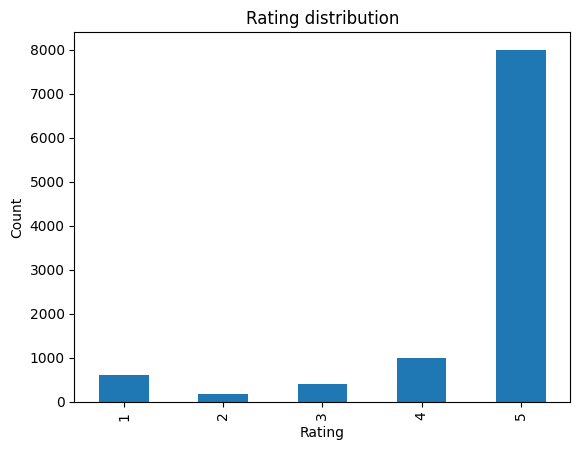

In [33]:
# 数值概览
print(
    df[["rating", "review_len", "word_count"]]
    .describe()
)

# 评分分布
plt.figure()
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [37]:
df["review_time"] = pd.to_datetime(df["review_time"], errors="coerce")

print("min:", df["review_time"].min())
print("max:", df["review_time"].max())
print("unique days:", df["review_time"].dt.date.nunique())
print("unique weeks:", df["review_time"].dt.to_period("W").nunique())


min: 2025-12-29 09:18:25
max: 2026-01-04 09:37:17
unique days: 5
unique weeks: 1


Hourly points: 80
hour
2025-12-29 09:00:00    4.650000
2025-12-29 10:00:00    4.470000
2026-01-01 04:00:00    4.577778
2026-01-01 05:00:00    4.433333
2026-01-01 06:00:00    4.500000
Name: rating, dtype: float64


C:\Users\y8qia\AppData\Local\Temp\ipykernel_31608\864481913.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time["hour"] = df_time["review_time"].dt.floor("H")


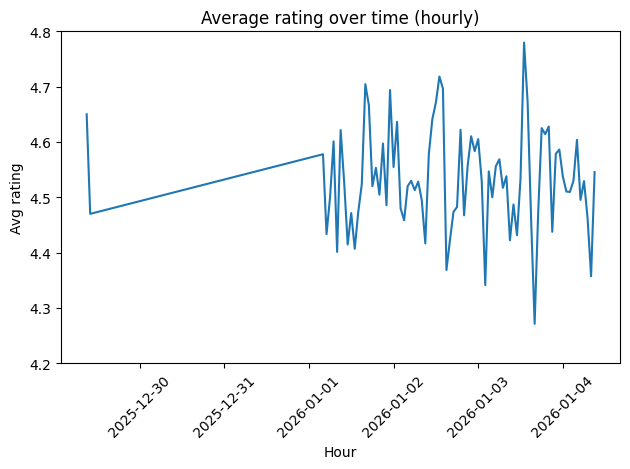

In [39]:
import matplotlib.pyplot as plt

# 只保留有时间和评分的数据
df_time = df.dropna(subset=["review_time", "rating"]).copy()

# 按小时取整
df_time["hour"] = df_time["review_time"].dt.floor("H")

hourly_avg = df_time.groupby("hour")["rating"].mean()

print("Hourly points:", len(hourly_avg))
print(hourly_avg.head())

# 可视化
plt.figure()
plt.plot(hourly_avg.index, hourly_avg.values)
plt.title("Average rating over time (hourly)")
plt.xlabel("Hour")
plt.ylabel("Avg rating")
plt.ylim(4.2, 4.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<Figure size 640x480 with 0 Axes>

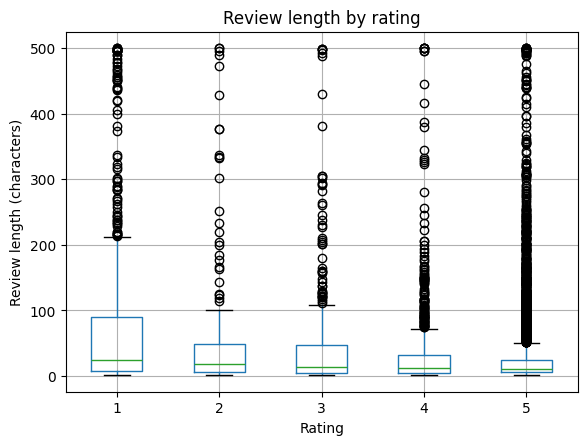

In [35]:
plt.figure()
df.boxplot(column="review_len", by="rating")
plt.suptitle("")
plt.title("Review length by rating")
plt.xlabel("Rating")
plt.ylabel("Review length (characters)")
plt.show()


Top app versions summary:
                n  avg_rating    avg_len
app_version                             
1.2025.350   8311    4.561665  30.786067
1.2025.343    382    4.560209  24.657068
1.2025.336    218    4.614679  25.857798
1.2025.329    147    4.462585  33.020408
1.2025.322     72    4.541667  28.597222
1.2025.315     54    4.462963  32.759259
1.2025.308     52    4.711538  26.192308
1.2025.302     47    4.340426  31.404255
1.2025.294     28    4.571429  35.250000
1.2025.283     25    4.280000  31.680000


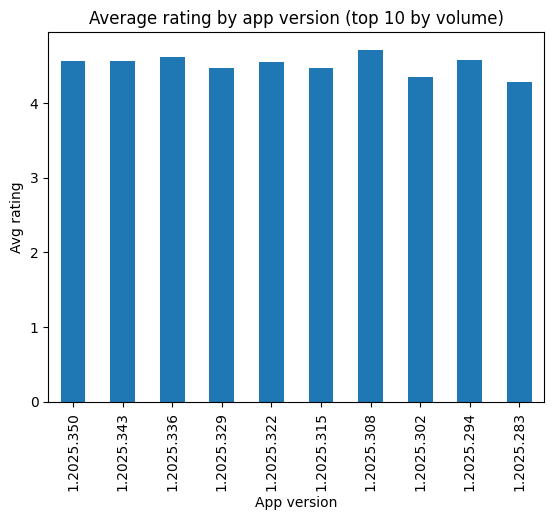

In [36]:
# 只看评分和版本都存在的
dv = df.dropna(subset=["app_version", "rating"]).copy()

# 只分析评论量最多的版本
top_versions = dv["app_version"].value_counts().head(10).index
dv = dv[dv["app_version"].isin(top_versions)]

version_stats = dv.groupby("app_version").agg(
    n=("rating", "size"),
    avg_rating=("rating", "mean"),
    avg_len=("review_len", "mean")
).sort_values("n", ascending=False)

print("Top app versions summary:")
print(version_stats)

plt.figure()
version_stats["avg_rating"].plot(kind="bar")
plt.title("Average rating by app version (top 10 by volume)")
plt.xlabel("App version")
plt.ylabel("Avg rating")
plt.show()


In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

sia = SentimentIntensityAnalyzer()

df = pd.read_csv(r"D:\intern PREOJECT\google\play_reviews_ingested.csv")

df["sentiment"] = df["review_text"].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df[["rating", "sentiment"]].head()


,rating,sentiment
0,3,0.0000
1,5,0.5994
2,5,0.5994
3,5,0.6249
4,1,0.0000


<Figure size 640x480 with 0 Axes>

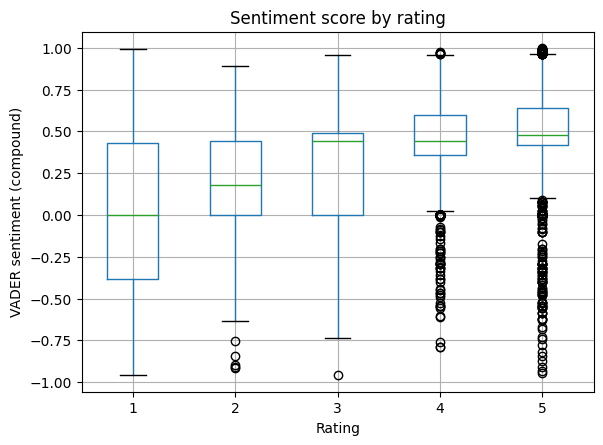

In [13]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="sentiment", by="rating")
plt.suptitle("")
plt.title("Sentiment score by rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.show()


In [14]:
sentiment_by_rating = df.groupby("rating")["sentiment"].mean()
print(sentiment_by_rating)


rating
1   -0.014019
2    0.170092
3    0.290376
4    0.402492
5    0.455445
Name: sentiment, dtype: float64


In [19]:
low_df = df[df["rating"].isin([1, 2])].copy()
print("Low-rating reviews:", len(low_df))


Low-rating reviews: 794


In [20]:
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [21]:
def clean_text_strict(text):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

low_df["clean_text_strict"] = low_df["review_text"].astype(str).apply(clean_text_strict)



In [22]:
from nltk.util import bigrams
from collections import Counter

bigrams_list = []
for text in low_df["clean_text_strict"]:
    tokens = text.split()
    bigrams_list.extend(list(bigrams(tokens)))

bigram_counts = Counter(bigrams_list)
bigram_counts.most_common(20)



[(('chat', 'gpt'), 21),
 (('good', 'app'), 10),
 (('best', 'app'), 8),
 (('bad', 'app'), 8),
 (('nice', 'app'), 6),
 (('bad', 'experience'), 6),
 (('please', 'fix'), 5),
 (('gives', 'wrong'), 5),
 (('bekar', 'hai'), 5),
 (('every', 'time'), 5),
 (('worst', 'app'), 5),
 (('wrong', 'information'), 4),
 (("can't", 'even'), 4),
 (('working', 'well'), 4),
 (('wrong', 'answers'), 4),
 (('gpt', 'plus'), 3),
 (('running', 'notes'), 3),
 (('give', 'good'), 3),
 (('app', 'hai'), 3),
 (('use', 'chat'), 3)]

In [18]:
from nltk.util import bigrams

bigrams_list = []
for text in low_df["clean_text"]:
    tokens = text.split()
    bigrams_list.extend(list(bigrams(tokens)))

bigram_counts = Counter(bigrams_list)
bigram_counts.most_common(15)


[(('this', 'app'), 46),
 (('it', 'is'), 38),
 (('very', 'bad'), 27),
 (('this', 'is'), 23),
 (('chat', 'gpt'), 22),
 (('i', 'have'), 21),
 (('when', 'i'), 21),
 (('to', 'be'), 20),
 (('is', 'not'), 19),
 (('and', 'it'), 18),
 (('i', 'dont'), 18),
 (('if', 'you'), 18),
 (('is', 'very'), 18),
 (('the', 'app'), 16),
 (('is', 'a'), 16)]

In [40]:
from nltk.corpus import stopwords
from nltk.util import bigrams
from collections import Counter
import re
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

low_df = df[df["rating"].isin([1, 2])].copy()

def clean_text(text):
    tokens = re.sub(r"[^a-zA-Z\s]", "", text.lower()).split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

bigrams_list = []
for text in low_df["review_text"]:
    tokens = clean_text(text)
    bigrams_list.extend(list(bigrams(tokens)))

bigram_counts = Counter(bigrams_list)
bigram_counts.most_common(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(('chat', 'gpt'), 22),
 (('good', 'app'), 10),
 (('bad', 'app'), 9),
 (('best', 'app'), 8),
 (('please', 'fix'), 7),
 (('wrong', 'information'), 7),
 (('worst', 'app'), 7),
 (('gives', 'wrong'), 6),
 (('dont', 'download'), 6),
 (('nice', 'app'), 6),
 (('bad', 'experience'), 6),
 (('dont', 'use'), 6),
 (('bekar', 'hai'), 5),
 (('doesnt', 'work'), 5),
 (('every', 'time'), 5),
 (('gpt', 'plus'), 4),
 (('cant', 'get'), 4),
 (('app', 'hai'), 4),
 (('cant', 'even'), 4),
 (('dont', 'like'), 4)]

In [41]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["review_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 640x480 with 0 Axes>

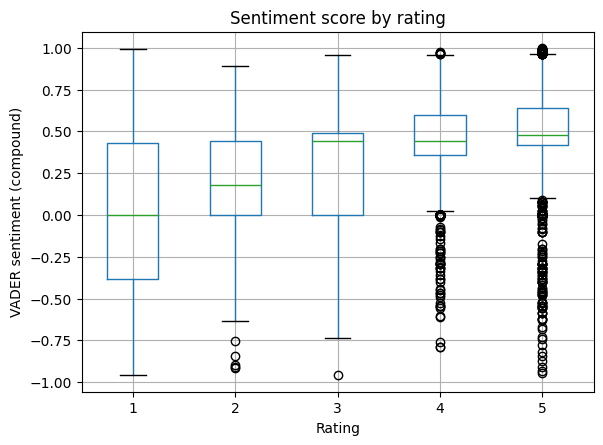

rating
1   -0.014019
2    0.170092
3    0.290376
4    0.402492
5    0.455445
Name: sentiment, dtype: float64


In [42]:
# 可视化
plt.figure()
df.boxplot(column="sentiment", by="rating")
plt.suptitle("")
plt.title("Sentiment score by rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.show()

# 数值总结
sentiment_by_rating = df.groupby("rating")["sentiment"].mean()
print(sentiment_by_rating)
